<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/single-shot-detector/notebooks/single-shot-detector/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Single Shot Detector

## 0. Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET
from google.colab import auth
from googleapiclient.discovery import build
from google.colab import userdata

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## 1. Download dataset.

In [7]:

KAGGLE_DATASET = "mbkinaci/fruit-images-for-object-detection"
BASE_DIR = "/content/fruit_data"
MODEL_TO_LOAD = "fruit_detector_v2.keras"
MODEL_TO_SAVE = "fruit_detector_v2.keras"

# Configurar Kaggle
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
if not os.path.exists(BASE_DIR):
    print("Download dataset...")
    !kaggle datasets download -d {KAGGLE_DATASET}
    !unzip -q fruit-images-for-object-detection.zip -d {BASE_DIR}
    print(f"Dataset download in {BASE_DIR}")
else:
    print("The dataset has been already downloaded.")

# Verificar estructura
print("Dataset Folders:", os.listdir(BASE_DIR))

The dataset has been already downloaded.
Dataset Folders: ['test_zip', 'train_zip']


## 2. Save and load model

In [3]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os
from tensorflow.keras.models import load_model

# Request permissions to access (read/write) the Google Drive Folder ID
GOOGLE_DRIVE_FOLDER_ID = "14LvaZfifLwoGsnIbwINaEZMSLEpP4E4-"
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 1. Función para guardar en Google Drive
def save_model_to_drive(model_obj, filename):
    # Primero guardamos localmente
    local_path = f"/content/{filename}"
    model_obj.save(local_path)
    print(f"Modelo guardado localmente en {local_path}")

    # Metadatos para Drive
    file_metadata = {
        'name': filename,
        'parents': [GOOGLE_DRIVE_FOLDER_ID]
    }

    media = MediaFileUpload(local_path, mimetype='application/octet-stream')

    # Subir
    print("Subiendo a Google Drive...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

    print(f"Modelo subido con ID: {file.get('id')}")

# 2. Función para cargar desde Google Drive
def load_model_from_drive(filename):
    print(f"Buscando {filename} en Drive...")
    # Buscar el archivo por nombre y carpeta padre
    query = f"name = '{filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print("No se encontró el archivo en Drive.")
        return None

    file_id = items[0]['id']
    local_path = f"/content/downloaded_{filename}"

    # Descargar
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(local_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Descargando {int(status.progress() * 100)}%.")

    # Cargar Modelo en Keras
    # IMPORTANTE: Necesitamos pasar la loss function custom
    print("Cargando modelo en memoria...")
    loaded_model = load_model(local_path, custom_objects={'yolo_style_loss': yolo_style_loss})
    print("Modelo cargado exitosamente.")
    return loaded_model

## 3. Pre-processing

Regroup the dataset annotations so that each unique image is associated with all its bounding boxes and labels, eliminating the duplicate image entries found in the current variables. You should re-process the data from `/content/fruit_data` or restructure the existing arrays.

After grouping, implement a **Target Encoder** to map the variable-length ground truth boxes to a fixed-size grid tensor (e.g., `7x7`). This encoder should assign objects to grid cells based on their center coordinates (similar to YOLO or simplified SSD), creating the target tensors required for training.

## 4. Data Restructuring & Target Encoding

### Subtask:
Reload the dataset to group annotations by image and implement a grid-based Target Encoder.


**Reasoning**:
I will reload the dataset grouping annotations by image and implement a grid-based target encoder to prepare the data for the single-shot detector model.



In [4]:
# Parámetros
GRID_SIZE = 7
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Mapeo de Clases
CLASS_MAP = {"apple": 0, "banana": 1, "orange": 2}
INV_CLASS_MAP = {0: "apple", 1: "banana", 2: "orange"}

def load_grouped_data(directory):
    images = []
    all_annotations = []

    # Iterate through all files in the directory
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image path
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                  print(f"Image not found: {img_path}")
                  continue

                # Get original dimensions
                size = root.find("size")
                w_orig = int(size.find("width").text)
                h_orig = int(size.find("height").text)

                if w_orig == 0 or h_orig == 0:
                  print(f"Invalid image dimensions: {img_path}")
                  continue

                # Find all valid objects
                objects = root.findall("object")
                img_boxes = []

                for obj in objects:
                    name = obj.find("name").text
                    if name in CLASS_MAP:
                        label = CLASS_MAP[name]
                        bndbox = obj.find("bndbox")
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)

                        # Normalize coordinates [0, 1]
                        cx_norm = (xmin + xmax) / (2 * w_orig)
                        cy_norm = (ymin + ymax) / (2 * h_orig)
                        w_norm = (xmax - xmin) / w_orig
                        h_norm = (ymax - ymin) / h_orig

                        # Store as [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label] for now
                        # Actually, keeping min/max for flexibility or converting to center/size directly?
                        # The instructions say "Normalize the bounding box coordinates to [0, 1]"
                        # Let's store [xmin/w, ymin/h, xmax/w, ymax/h, label]
                        img_boxes.append([
                            xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label
                        ])

                if img_boxes:
                    # Load and resize image
                    try:
                        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                        img_arr = img_to_array(img) / 255.0
                        images.append(img_arr)
                        all_annotations.append(img_boxes)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype="float32"), all_annotations

print("Reloading Train Data...")
X_train, train_bboxes = load_grouped_data(os.path.join(BASE_DIR, "train_zip", "train"))

print("Reloading Test Data...")
X_test, test_bboxes = load_grouped_data(os.path.join(BASE_DIR, "test_zip", "test"))

print(f"Grouped X_train shape: {X_train.shape}")
print(f"Grouped X_test shape: {X_test.shape}")

# Target Encoder for SSD/YOLO style grid
def encode_target(bboxes_list, grid_size=GRID_SIZE, num_classes=3):
    # Output: (7, 7, 8) -> [conf, cx, cy, w, h, c0, c1, c2]
    target = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in bboxes_list:
        xmin, ymin, xmax, ymax, label = box

        # Calculate Center and Size (normalized global)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin

        # Determine grid cell
        col = int(cx * grid_size)
        row = int(cy * grid_size)

        # Boundary check
        col = min(col, grid_size - 1)
        row = min(row, grid_size - 1)

        # Populate tensor if empty (or overwrite)
        # We set confidence to 1
        if target[row, col, 0] == 0:
            target[row, col, 0] = 1.0
            target[row, col, 1:5] = [cx, cy, w, h]
            target[row, col, 5 + int(label)] = 1.0

    return target

# Apply encoder
print("Encoding targets...")
y_train = np.array([encode_target(bboxes) for bboxes in train_bboxes])
y_test = np.array([encode_target(bboxes) for bboxes in test_bboxes])

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Custom Yolo Style loss function
def yolo_style_loss(y_true, y_pred):
    # y_true shape: (batch, 7, 7, 8)
    # Index 0: Confidence (1 if object, 0 otherwise)
    # Index 1-4: Box coordinates (cx, cy, w, h)
    # Index 5-7: Classes (one-hot)

    # Masks
    object_mask = y_true[..., 0]
    no_object_mask = 1.0 - object_mask

    # 1. Coordinate Loss (Weighted by 5.0)
    # Calculate MSE for box coordinates (indices 1-4) only where object exists
    # Sum over coordinates (axis -1)
    coord_loss = tf.reduce_sum(tf.square(y_true[..., 1:5] - y_pred[..., 1:5]), axis=-1)
    coord_loss = object_mask * coord_loss

    # 2. Object Confidence Loss
    obj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    obj_conf_loss = object_mask * obj_conf_loss

    # 3. No-Object Confidence Loss (Weighted by 0.5)
    noobj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    noobj_conf_loss = no_object_mask * noobj_conf_loss

    # 4. Class Loss
    # MSE for class probabilities
    class_loss = tf.reduce_sum(tf.square(y_true[..., 5:] - y_pred[..., 5:]), axis=-1)
    class_loss = object_mask * class_loss

    # Total Loss
    loss = (5.0 * coord_loss +
            obj_conf_loss +
            0.5 * noobj_conf_loss +
            class_loss)

    # Sum over the grid (7x7) to get loss per image
    return tf.reduce_sum(loss, axis=[1, 2])

Reloading Train Data...
Invalid image dimensions: /content/fruit_data/train_zip/train/banana_75.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_4.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_51.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_68.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_11.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/banana_53.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/banana_60.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_22.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/banana_71.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/apple_42.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/mixed_16.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orange_30.jpg
Invalid image dimensions: /content/fruit_data/train_zip/train/orang

### `encode_target`

The `encode_target` function acts as a bridge between human-readable annotations (bounding boxes) and the neural network's required input format. It converts a list of object boxes into a fixed-size 3D grid tensor.

**Goal:** Transform variable-length lists of boxes into a `(7, 7, 8)` tensor.

1.  **Grid Initialization:**
    *   Creates a zero-filled tensor of shape `(Grid Size, Grid Size, 8)`.
    *   Each cell in this 7x7 grid corresponds to a specific region of the image.

2.  **Center & Size Calculation:**
    *   For each ground truth box, it converts corner coordinates `(xmin, ymin, xmax, ymax)` into:
        *   **Center (`cx`, `cy`):** Where the object is located.
        *   **Size (`w`, `h`):** How big the object is.

3.  **Grid Cell Assignment:**
    *   **The Golden Rule:** The specific grid cell that contains the **center point** of the object is responsible for detecting it.
    *   It calculates the column and row indices: `col = int(cx * 7)`, `row = int(cy * 7)`.

4.  **Tensor Population:**
    *   At the calculated `[row, col]` index, it fills the depth vector `[8]` with:
        *   **Index 0:** Confidence = `1.0` (Object Present).
        *   **Index 1-4:** Coordinates `[cx, cy, w, h]`.
        *   **Index 5-7:** One-hot encoded Class Label (e.g., `[1, 0, 0]` for Apple).

**Output Vector Structure:**
`[ Confidence, cx, cy, w, h, Class0, Class1, Class2 ]`

### `yolo_style_loss`

The `yolo_style_loss` function is a custom loss function designed to handle multiple objectives simultaneously (box regression and classification). It is calculated by summing four main components:

1.  **Coordinate Loss:**
    *   Measures how far the predicted box is from the actual one (center `x, y` and size `w, h`).
    *   It is calculated **only if there is an object** in that cell.
    *   It is multiplied by `5.0` to give more importance to finding the exact position.

2.  **Object Confidence Loss:**
    *   Measures if the model correctly predicted that there **IS** an object (Confidence close to 1).

3.  **No-Object Confidence Loss:**
    *   Measures if the model correctly predicted that there is **NO** object (Confidence close to 0).
    *   It is multiplied by `0.5` so the model doesn't focus too much on the background (since most of the image is background).

4.  **Class Loss:**
    *   Measures if the model got the fruit type right (Apple, Banana, Orange).
    *   It is calculated only if there is an object.

**Final Formula:**
`Loss = (5 * Coord) + ObjConf + (0.5 * NoObjConf) + Class`
```

## 5. Build VGG16-SSD Architecture

### Subtask:
Construct a simplified object detection model using VGG16 as the backbone and a custom detection head.


**Reasoning**:
I will define and instantiate the simplified VGG16-based SSD model architecture. This involves importing necessary layers, setting up the pre-trained backbone, freezing its weights, adding the custom detection head with specific convolutional layers, and verifying the output shape with a model summary.



VGG16-SSD is a hybrid architecture that combines two main parts for object detection:

The Backbone (VGG16):

Acts as the "feature extractor."
It is a deep neural network pre-trained on millions of images (ImageNet).
In this notebook, we remove its top layers (classification) and keep the convolutional base. This converts an input image (224x224) into a rich, compressed feature map (7x7x512).
Why it's used: It allows the model to "see" edges, textures, and complex shapes without having to learn from scratch (Transfer Learning).
The SSD Head (Single Shot Detector):

It is the custom part we add at the end.
It's called "Single Shot" because it predicts boxes and classes in a single pass of the network, rather than scanning the image multiple times.
How it works: It takes the 7x7 feature map from VGG16 and applies a final convolutional layer to predict the output tensor (7, 7, 8).
In summary: VGG16 understands what is in the image, and the SSD head uses that understanding to draw the boxes and say which fruits they are.

In [5]:
from tensorflow.keras.layers import Conv2D, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Define Input
    input_layer = Input(shape=input_shape)

    # Load VGG16 pre-trained on ImageNet, excluding top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the weights of the VGG16 base model
    base_model.trainable = False

    # The output of VGG16 (block5_pool) is 7x7x512 for 224x224 input
    x = base_model.output

    # Detection Head
    # Add a convolutional layer for feature adaptation
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='detection_conv')(x)
    x = Dropout(0.5)(x)

    # Final prediction layer
    # Filters = 5 (confidence + x + y + w + h) + num_classes
    # Shape will be (7, 7, 8)
    output_layer = Conv2D(5 + num_classes, (1, 1), activation='sigmoid', name='prediction_head')(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="VGG16_SSD_Simple")
    return model

# Instantiate the model
model = create_model()

# Verify architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_SSD_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_conv (Conv2D)         │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction_head (Conv2D)        │ (None, 7, 7, 8)        │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,600 (65.15 MB)

 Trainable params: 2,363,912 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 6. Train


**Reasoning**:
I will define the custom YOLO-style loss function as specified, compile the model using the Adam optimizer, and train the model for 30 epochs using the prepared training and testing datasets.



In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=yolo_style_loss)

# Train
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test)
)

# Saving model
save_model_to_drive(model, MODEL_TO_SAVE)

Starting training...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 9.6190 - val_loss: 4.6147
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 5.2335 - val_loss: 4.0783
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 4.8394 - val_loss: 3.7651
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 4.3318 - val_loss: 3.5805
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 4.1537 - val_loss: 3.4122
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.8040 - val_loss: 3.3012
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.9169 - val_loss: 3.2056
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 3.3186 - val_loss: 3.0592
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.1876 - val_loss: 2.9117
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 2.8551 - val_loss: 2.7888
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 2.8300 - val_loss: 2.6897
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - lo

Modelo subido con ID: 1iL_Xsr-ZwZKFmxDwnRVoyr5mHa9z2hIC


## 7. Load saved model

In [8]:
# 2. Cargar en variable nueva
loaded_fruit_model = load_model_from_drive(MODEL_TO_LOAD)

Buscando fruit_detector_v2.keras en Drive...
Descargando 100%.
Cargando modelo en memoria...
Modelo cargado exitosamente.


## 8. NMS Implementation & Inference

### Subtask:
Implement the Non-Max Suppression (NMS) algorithm to filter out overlapping boxes and select the best predictions. Create a visualization function to run inference on test images and display the final detected boxes with their labels.


**Reasoning**:
I will implement the `decode_prediction` function to process the model's output tensor, converting grid-based predictions to bounding boxes and applying Non-Max Suppression (NMS) to remove duplicates. Then, I will create a `visualize_predictions` function to run inference on test images and display the results with bounding boxes and labels using matplotlib. Finally, I will execute this on random test samples.



In [12]:
import matplotlib.patches as patches
import random

def decode_prediction(prediction, conf_thresh=0.5, iou_thresh=0.4):
    """
    Decodes the (7, 7, 8) output tensor and applies NMS.
    Returns: boxes (xmin, ymin, xmax, ymax), scores, class_indices
    """
    # prediction shape: (7, 7, 8)
    grid_size = prediction.shape[0]

    boxes = []
    scores = []
    class_indices = []

    # 1. Extract all candidate boxes
    for r in range(grid_size):
        for c in range(grid_size):
            # Index 0 is object confidence
            conf = prediction[r, c, 0]

            if conf >= conf_thresh:
                # Geometry: cx, cy, w, h (global normalized)
                cx, cy, w, h = prediction[r, c, 1:5]

                # Classes: indices 5-7
                class_probs = prediction[r, c, 5:]
                cls_idx = np.argmax(class_probs)

                # Calculate xmin, ymin, xmax, ymax
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                # TF NMS expects [ymin, xmin, ymax, xmax]
                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)
                class_indices.append(cls_idx)

    if not boxes:
        return np.array([]), np.array([]), np.array([])

    boxes = np.array(boxes)
    scores = np.array(scores)
    class_indices = np.array(class_indices)

    # 2. Apply NMS
    # tf.image.non_max_suppression returns indices of boxes to keep
    indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )
    indices = indices.numpy()

    if len(indices) == 0:
         return np.array([]), np.array([]), np.array([])

    selected_boxes = boxes[indices]
    selected_scores = scores[indices]
    selected_classes = class_indices[indices]

    # Convert [ymin, xmin, ymax, xmax] back to [xmin, ymin, xmax, ymax] for plotting
    final_boxes = selected_boxes[:, [1, 0, 3, 2]]

    return final_boxes, selected_scores, selected_classes

def visualize_predictions(model, X_set, num_samples=3):
    indices = random.sample(range(len(X_set)), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        img = X_set[idx]

        # Model Inference
        # Expand dims to (1, 224, 224, 3)
        pred_tensor = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

        # Decode
        boxes, scores, classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

        # Plot
        ax = plt.subplot(num_samples, 1, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Sample {idx}")

        height, width, _ = img.shape

        for box, score, cls_idx in zip(boxes, scores, classes):
            xmin, ymin, xmax, ymax = box

            # Scale to image size
            x = xmin * width
            y = ymin * height
            w = (xmax - xmin) * width
            h = (ymax - ymin) * height

            # Draw Rectangle
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Label
            label_name = INV_CLASS_MAP[cls_idx]
            label_text = f"{label_name} {score:.2f}"
            plt.text(x, y - 5, label_text, color='white', fontsize=12, backgroundcolor='red')

    plt.tight_layout()
    plt.show()


### Prepare Testing (using test dataset)

In [14]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os


# 3. Refactorizar test_random_sample para recibir modelo
def test_random_sample(model_to_test):
    # 1. Pick a random index
    idx = random.randint(0, len(X_test) - 1)

    # 2. Get Data
    img = X_test[idx]
    gt_data = test_bboxes[idx]

    # 3. Model Inference
    input_img = np.expand_dims(img, axis=0)
    pred_tensor = model_to_test.predict(input_img, verbose=0)[0]

    # Decode predictions (usa la misma función decode definida anteriormente)
    pred_boxes, pred_scores, pred_classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

    # 4. Visualization
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(f"Test Sample #{idx} (Loaded Model)")
    ax.axis('off')

    height, width, _ = img.shape

    # Plot Ground Truth
    for box in gt_data:
        xmin, ymin, xmax, ymax, label_idx = box
        class_name = INV_CLASS_MAP[int(label_idx)]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        plt.text(x, y - 5, f"GT: {class_name}", color='lime', fontsize=10, fontweight='bold')

    # Plot Predictions
    if len(pred_boxes) == 0:
        plt.text(10, 10, "No objects detected", color='red', backgroundcolor='white')

    for box, score, cls_idx in zip(pred_boxes, pred_scores, pred_classes):
        xmin, ymin, xmax, ymax = box
        class_name = INV_CLASS_MAP[cls_idx]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y + h + 15, f"Pred: {class_name} ({score:.2f})", color='red', fontsize=10, fontweight='bold')

    plt.show()


# 2. Cargar en variable nueva
if not loaded_fruit_model:
  loaded_fruit_model = load_model_from_drive(MODEL_TO_LOAD)


### Test random samples

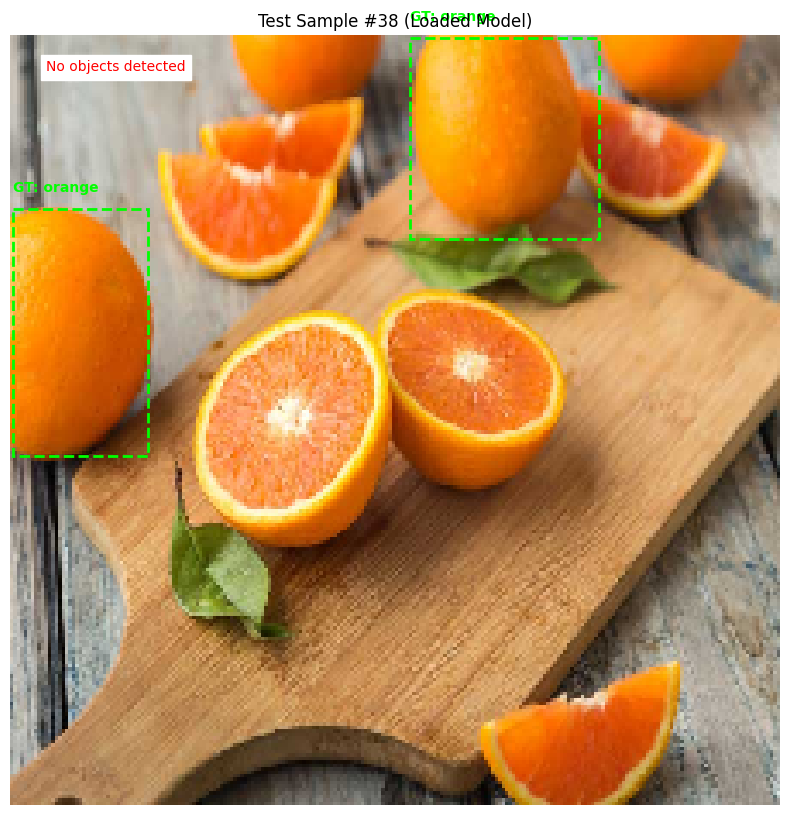

In [21]:
# 3. Testear modelo cargado
if loaded_fruit_model:
    test_random_sample(loaded_fruit_model)